### Run vanilla `scarlet` for ~5476 LSBG candidates at 0.02 < z < 0.04.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [178]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [7]:
lsbg_cat = Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 5576


In [183]:
lsbg = lsbg_cat[int(np.where(lsbg_cat['viz-id'] == 40485)[0][0])]

In [169]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [175]:
fitter = ScarletFitter(method='wavelet', tigress=True, starlet_thresh=0.5,
                       log_dir='./log/', 
                       figure_dir='./Figure/',
                       model_dir='./Model/',
                       prefix='test', index=0, show_figure=True)
fitter.load_data(data, lsbg_coord)

#### Step-by-step

In [147]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    6 stars from Gaia are masked!


In [148]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 112 objects


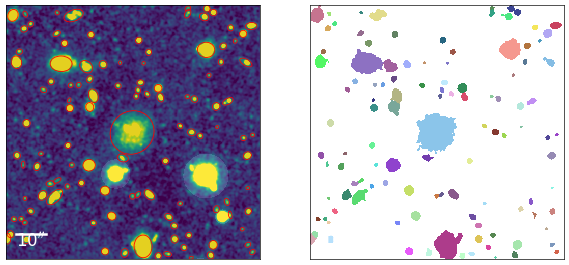

In [149]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.02
        
fitter._first_detection(first_dblend_cont)

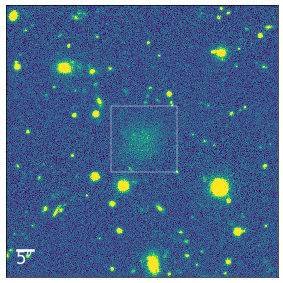

In [150]:
fitter._estimate_box(fitter.cen_obj)

In [151]:
fitter._mask_stars_outside_box()

    6 stars from Gaia are masked!


    Detected 95 objects


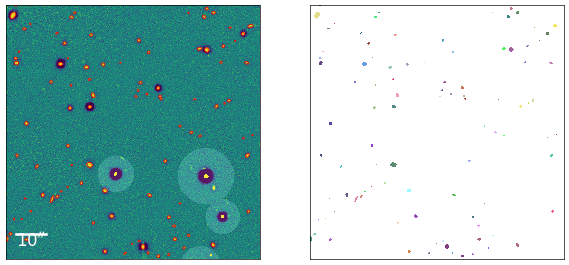

In [152]:
fitter._cpct_obj_detection()

    Detected 57 objects


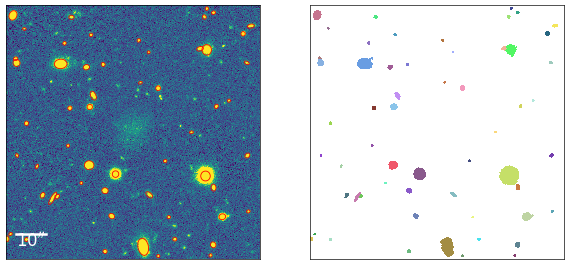

In [153]:
fitter._big_obj_detection()

In [154]:
fitter._merge_catalogs()

In [155]:
fitter._construct_obs_frames()

In [158]:
fitter._add_sources()

  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.20, starlet_thresh = 0.50 (contam_ratio = 0.00).
    Total number of sources: 2


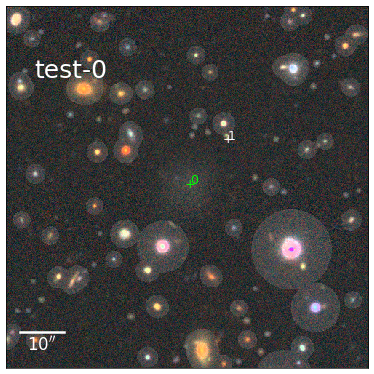

In [159]:
fig = kz.display.display_scarlet_sources(
        fitter.data,
        fitter._sources,
        show_ind=None,
        stretch=1,
        Q=1,
        minimum=-0.3,
        show_mark=True,
        scale_bar_length=10,
        add_text=f'{fitter.prefix}-{fitter.index}')

    Optimizaiton: Succeed for e_rel = 0.0001 with 39 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 59 iterations! Try higher accuracy!
  - After 59 iterations, logL = 997501.44
    Elapsed time for fitting: 14.53 s


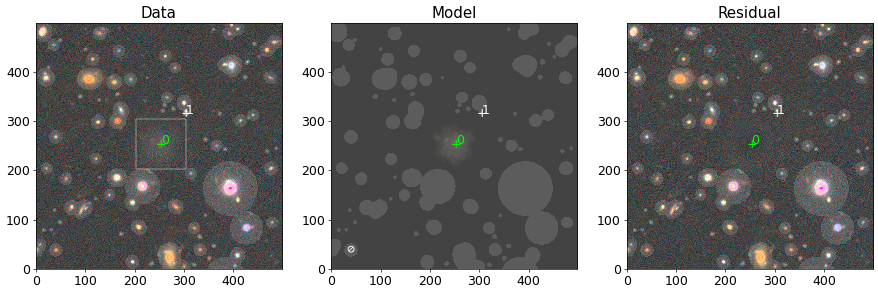

In [160]:
fitter._optimize()

In [161]:
fitter._find_sed_ind()

  - Components [0] are considered as the target galaxy.


In [162]:
fitter._gen_final_mask()

  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/test-0-trained-model-wavelet.df


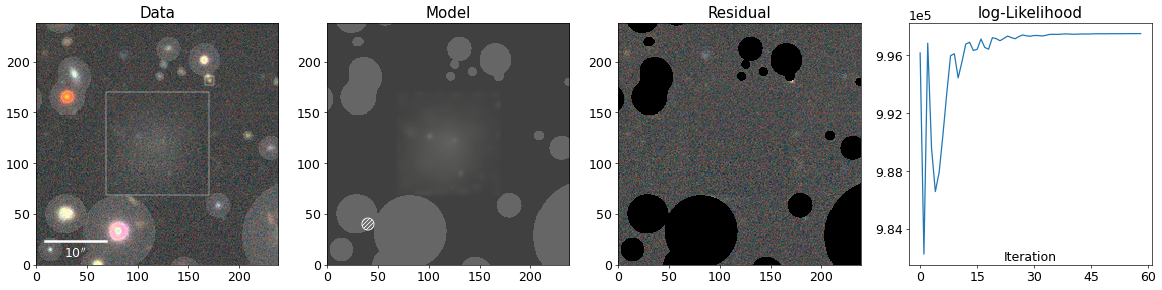

In [163]:
fitter._display_results()